In [1]:
import trading_strategy
import torch
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

In [2]:
# Define parameters
sigma_x = 0.2
sigma_y = 0.3
kappa = 0.5
X_0=100
Y_0=100

def synthetic_pairs(batch_size: int, T: int):
    n_assets = 2
    price_paths = torch.zeros(batch_size, T, n_assets)
    
    price_paths[:,:,0] = X_0
    price_paths[:,:,1] = Y_0
    delta_t = 1/T

    for t in range(1,T):
        # price_paths[:,t,0] = price_paths[:,t-1,0] + sigma_x*price_paths[:,t-1,0]*torch.randn(batch_size)*np.sqrt(delta_t)
        price_paths[:,t,0] = price_paths[:,t-1,0] + sigma_x*torch.randn(batch_size)*np.sqrt(delta_t)
        # price_paths[:,t,1] = price_paths[:,t-1,1] + kappa*(price_paths[:,t-1,0]-price_paths[:,t-1,1])*delta_t + sigma_y*price_paths[:,t-1,1]*torch.randn(batch_size)*np.sqrt(delta_t)
        price_paths[:,t,1] = price_paths[:,t-1,1] + kappa*(price_paths[:,t-1,0]-price_paths[:,t-1,1])*delta_t + sigma_y*torch.randn(batch_size)*np.sqrt(delta_t)

    return price_paths

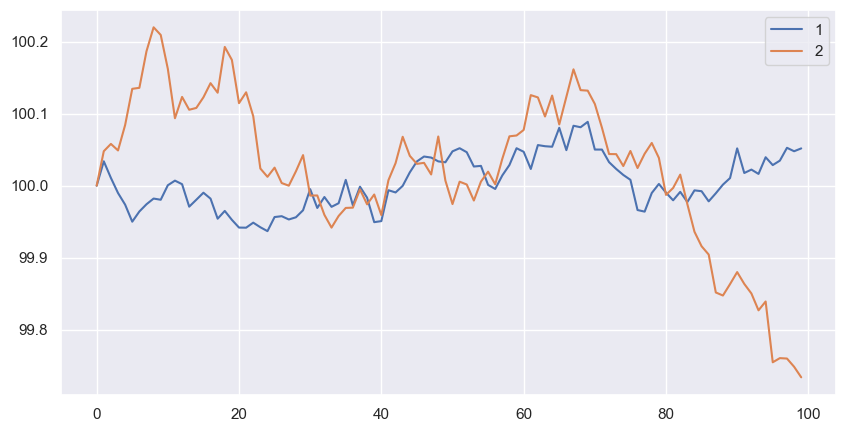

function compute_signature took 7.30s
mu_sig successfully computed
sigma_sig successfully computed
function compute_sigma_sig took 7.45s
lambda successfully computed
Fitting successful.



In [3]:
depth = 3
delta = 0.3
ts = trading_strategy.TradingStrategy(depth, delta)
batch_size = 10
T = 100 # number of time steps
synthetic_batch_stock_data = synthetic_pairs(batch_size, T)
info_data = torch.zeros(batch_size, T, 0) # no info

# let's look at our synthetic data
plt.figure(figsize=(10,5))
example_pair_path = synthetic_batch_stock_data[0]
plt.plot(example_pair_path[:,0], label='1')
plt.plot(example_pair_path[:,1], label='2')
plt.legend()
plt.show()

ts.fit(synthetic_batch_stock_data, info_data)

In [18]:
l1 = ts.functionals[0]
utils.print_signature(l1, ts.Z_dimension, ts.depth)

l2 = ts.functionals[1]
utils.print_signature(l2, ts.Z_dimension, ts.depth)

Level 0:
tensor([-0.0972])
Level 1:
tensor([0.0010, 0.9748, 0.5473])
Level 2:
tensor([-4.7923e-06,  2.0522e-02, -8.0684e-04,  4.3162e-03,  6.2394e+00,
        -2.8273e+00, -2.7217e-02,  3.3556e+00, -4.3220e+00])
Level 3:
tensor([ 1.7035e-07, -4.8003e-04,  4.6647e-04, -7.9787e-05, -3.8059e-01,
        -2.5602e-02,  3.0037e-04, -2.6302e-01,  1.5689e-01,  4.7488e-04,
         5.0865e-01, -7.4310e-01,  1.2101e-01,  3.5333e+02, -4.2109e+01,
         2.2889e-01, -3.2196e+01, -1.9591e+02, -2.2351e-05, -3.0717e-01,
        -1.0509e-01,  2.9944e-01,  5.1008e+00, -1.3210e+01, -1.1978e-01,
         1.5307e+02,  6.7379e+00])
Level 0:
tensor([-41.3478])
Level 1:
tensor([-1.1151e-01, -3.0122e+02, -1.9649e+01])
Level 2:
tensor([-2.1329e-03,  1.0180e+00,  5.6178e+00, -1.7611e+01, -2.7335e+03,
        -3.6997e+03,  3.5668e+00, -1.4524e+03, -3.9992e+03])
Level 3:
tensor([-6.3045e-04,  1.5730e-01,  6.2973e-02,  9.0563e-01, -1.7515e+02,
         3.0577e+00, -4.1797e-01, -1.0658e+02,  2.1753e+02, -9.7908e-

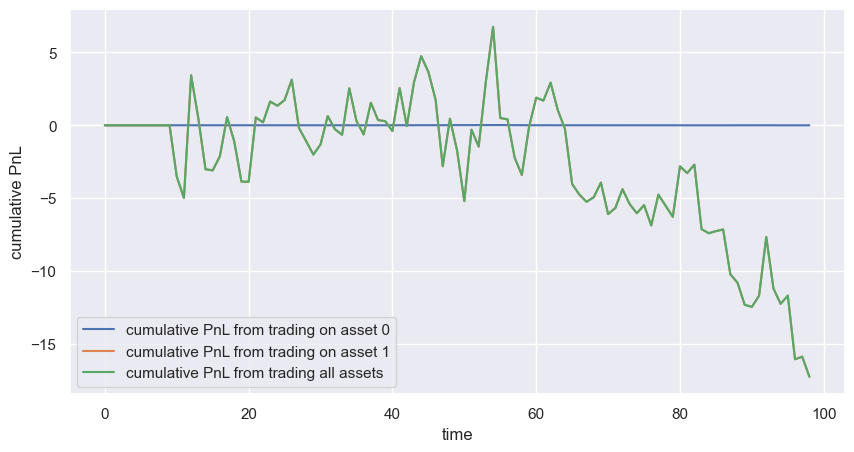

In [19]:
path_index = 9 # path we want to look at
seen_stock_data = synthetic_batch_stock_data[path_index]
seen_info = info_data[path_index]
# let's trade on this path
xi = ts.trade(seen_stock_data, seen_info, min_steps=10)
daily_pnl = ts.compute_pnl(seen_stock_data, xi)
cum_pnl = torch.cumsum(daily_pnl, dim=0)
utils.plot_cum_pnl(cum_pnl)

## Let's try mean-reverting ts

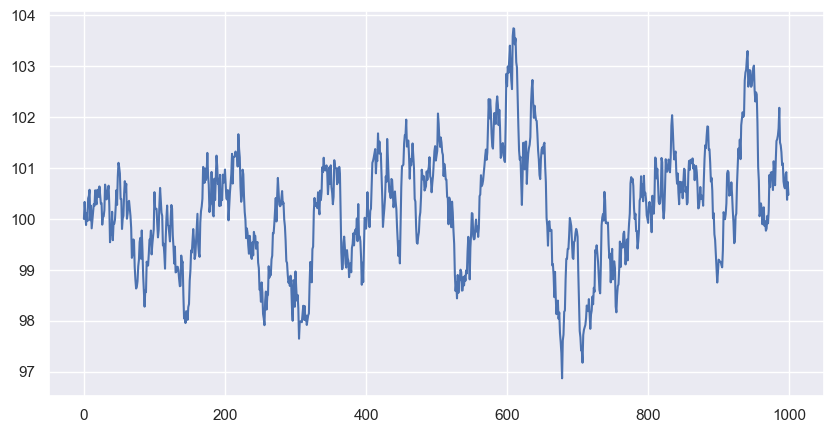

In [4]:
def synthetic_mean_reverting(batch_size: int, T: int, X_0: float, sigma_x: float, kappa: float):
    price_paths = torch.zeros(batch_size, T)
    
    price_paths[:,0] = X_0
    delta_t = 1/T

    for t in range(1,T):
        price_paths[:,t] = price_paths[:,t-1] + kappa*(X_0-price_paths[:,t-1])*delta_t + sigma_x*price_paths[:,t-1]*torch.randn(batch_size)*np.sqrt(delta_t)

    return price_paths

X_0 = 100
sigma_x = 0.1
kappa = 50
batch_size = 1000
T = 1000
synthetic_batch_stock_data = synthetic_mean_reverting(batch_size, T, X_0, sigma_x, kappa)
# unsqueeze to get a batch dimension
synthetic_batch_stock_data = synthetic_batch_stock_data.unsqueeze(2)

# let's look at our synthetic data
plt.figure(figsize=(10,5))
example_path = synthetic_batch_stock_data[0]
plt.plot(example_path)
plt.show()


ts = trading_strategy.TradingStrategy(depth, delta)
info_data = torch.zeros(batch_size, T, 0) # no info
ts.fit(synthetic_batch_stock_data, info_data)

In [16]:
ts.functionals

[tensor([ 1.6419e+00, -2.0776e-03,  1.0331e-01,  3.8452e-06, -1.0336e-04,
         -2.0672e-04, -1.1461e-05])]

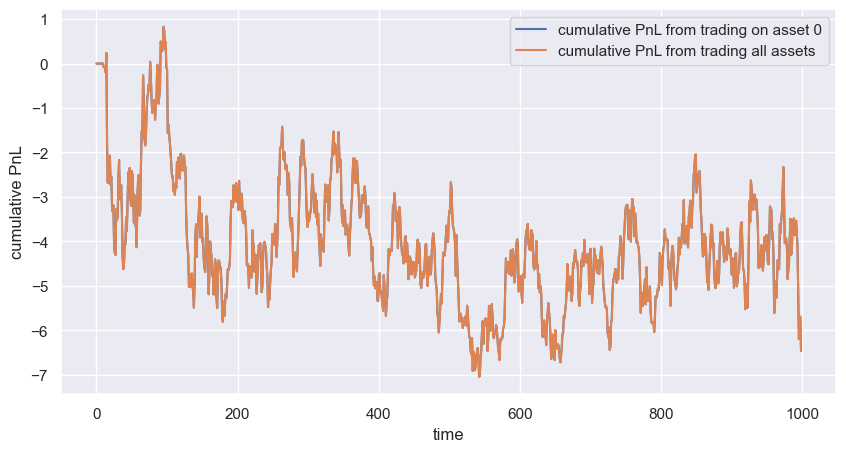

In [15]:
path_index = 0 # path we want to look at
seen_stock_data = synthetic_batch_stock_data[path_index]
seen_info = info_data[path_index]

# let's trade on this path
xi = ts.trade(seen_stock_data, seen_info, min_steps=10)
daily_pnl = ts.compute_pnl(seen_stock_data, xi)
cum_pnl = torch.cumsum(daily_pnl, dim=0)
utils.plot_cum_pnl(cum_pnl)

In [9]:
l1 = ts.functionals[0]

utils.print_signature(l1, ts.Z_dimension, ts.depth)

Level 0:
tensor([1.2531])
Level 1:
tensor([-0.0016, -0.1786])
Level 2:
tensor([ 3.1469e-06,  1.7873e-04,  3.5746e-04, -4.3325e-06])
